# Grid search results analysis

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from itertools import combinations
import math
from glob import glob

FONTSIZE=14

In [2]:
data_df = pd.read_pickle('data/grid_search/grid_search.pkl')
data_df['dtype'].astype('str')
data_df.head()

,features,bond_dim,batch_size,initialize,dtype,loss,train_acc,test_acc,train_acc0,test_acc0,time
0,4,2,16,True,torch.float64,0.001245,1.0000,1.0,0.6684,0.664,200.066460
1,4,2,16,False,torch.float64,0.002246,0.9997,1.0,0.3502,0.338,194.302091
2,4,2,32,True,torch.float64,0.001204,1.0000,1.0,0.6655,0.673,131.457987
3,4,2,32,False,torch.float64,0.001216,1.0000,1.0,0.3023,0.305,126.006699
4,4,2,128,True,torch.float64,0.001168,1.0000,1.0,0.5006,0.501,77.283521


In [3]:
# divide float and complex
float_df = data_df[data_df['dtype'] == 'torch.float64'].drop(columns=['dtype'])
complex_df = data_df[data_df['dtype'] == 'torch.complex128'].drop(columns=['dtype'])

float_df.head()

,features,bond_dim,batch_size,initialize,loss,train_acc,test_acc,train_acc0,test_acc0,time
0,4,2,16,True,0.001245,1.0000,1.0,0.6684,0.664,200.066460
1,4,2,16,False,0.002246,0.9997,1.0,0.3502,0.338,194.302091
2,4,2,32,True,0.001204,1.0000,1.0,0.6655,0.673,131.457987
3,4,2,32,False,0.001216,1.0000,1.0,0.3023,0.305,126.006699
4,4,2,128,True,0.001168,1.0000,1.0,0.5006,0.501,77.283521


## float vs complex

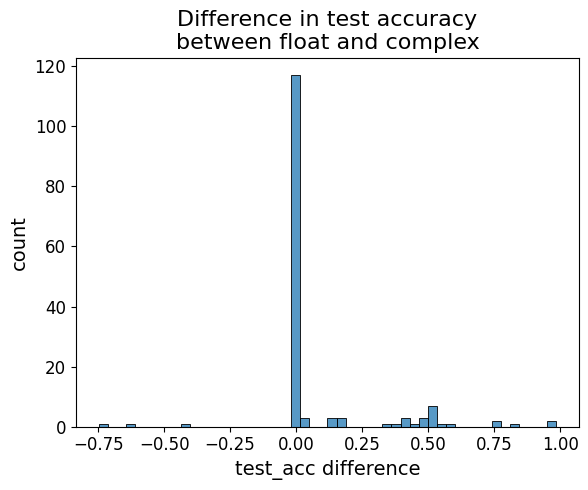

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.histplot(float_df.set_index(['features', 'bond_dim', 'batch_size', 'initialize'])['test_acc'] - complex_df.set_index(['features', 'bond_dim', 'batch_size', 'initialize'])['test_acc'], bins=50, ax=ax)
ax.set_title('Difference in test accuracy\nbetween float and complex', fontsize=FONTSIZE+2)
ax.set_xlabel('test_acc difference', fontsize=FONTSIZE)
ax.set_ylabel('count', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()

fig.savefig('data/grid_search/float_complex_diff.png', dpi=600)

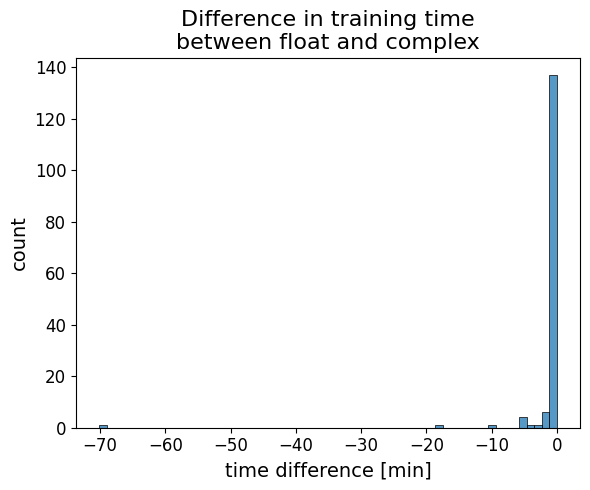

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.histplot((float_df.set_index(['features', 'bond_dim', 'batch_size', 'initialize'])['time'] - complex_df.set_index(['features', 'bond_dim', 'batch_size', 'initialize'])['time']) / 60., bins=60, ax=ax)
ax.set_title('Difference in training time\nbetween float and complex', fontsize=FONTSIZE+2)
ax.set_xlabel('time difference [min]', fontsize=FONTSIZE)
ax.set_ylabel('count', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()

fig.savefig('data/grid_search/float_complex_timediff.png', dpi=600)

## Initialization

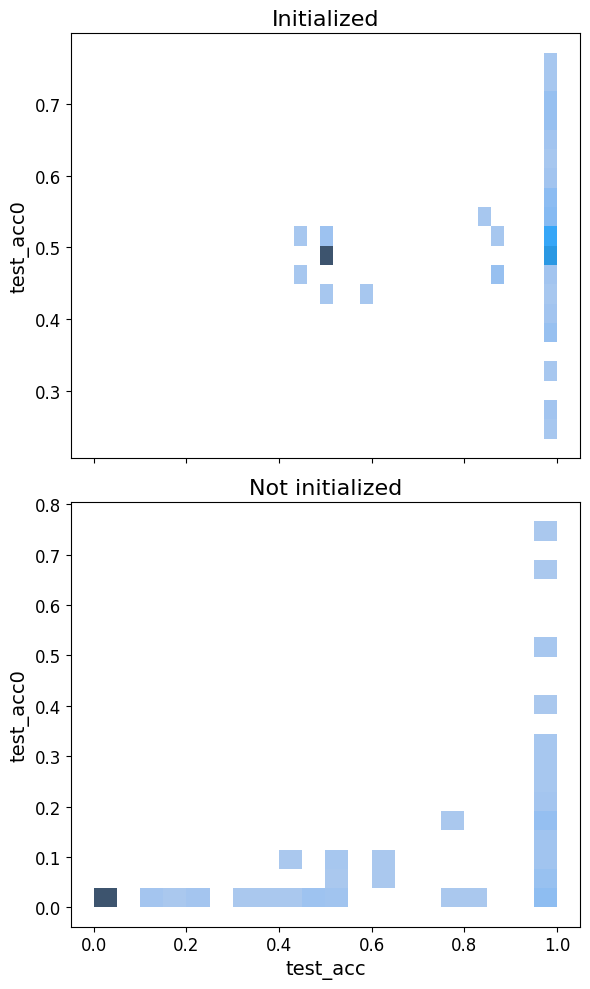

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), sharex=True)
df_initTrue = data_df[data_df['initialize'] == True].copy()
df_initFalse = data_df[data_df['initialize'] == False].copy()
df_initTrue['diff'] = df_initTrue['test_acc'] - df_initTrue['test_acc0']
df_initFalse['diff'] = df_initFalse['test_acc'] - df_initFalse['test_acc0']
sns.histplot(df_initTrue[['test_acc', 'test_acc0']], x = 'test_acc', y='test_acc0', bins=20, ax=ax[0])
sns.histplot(df_initFalse[['test_acc','test_acc0']], x = 'test_acc', y='test_acc0', bins=20, ax=ax[1])
ax[0].set_title('Initialized', fontsize=FONTSIZE+2)
ax[1].set_title('Not initialized', fontsize=FONTSIZE+2)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=FONTSIZE)
ax[1].set_xlabel(ax[1].get_xlabel(), fontsize=FONTSIZE)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=FONTSIZE)
ax[1].set_ylabel(ax[1].get_ylabel(), fontsize=FONTSIZE)
ax[0].tick_params(labelsize=FONTSIZE-2)
ax[1].tick_params(labelsize=FONTSIZE-2)

#fig.suptitle('Difference in test accuracy\nafter and before training', fontsize=FONTSIZE+2)
fig.tight_layout()

fig.savefig('data/grid_search/init_diff.png', dpi=600)

## confusion matrices

In [8]:
def heat_pairplot(df, variables, value='train_acc', fmt='.3f'):
    # get all combinations of variables
    pairs = list(combinations(variables, 2))

    rows = math.floor(len(pairs)**0.5)
    cols = math.ceil(len(pairs)/rows)
    fig, ax = plt.subplots(rows, cols, figsize=(8*cols, 6*rows))
    if len(pairs) == 1:
        ax = np.array([ax])
    else:
        ax = ax.flatten()

    # plot
    for i, combo in enumerate(pairs):
        sns.heatmap(df.pivot_table(index=combo[0], columns=combo[1], values=value, aggfunc='mean'), ax=ax[i], annot=True, fmt=fmt, cmap='Blues')
        ax[i].set_title(f'{combo[0]} vs {combo[1]}')
        ax[i].set_xlabel(combo[1])
        ax[i].set_ylabel(combo[0])

    return fig, ax

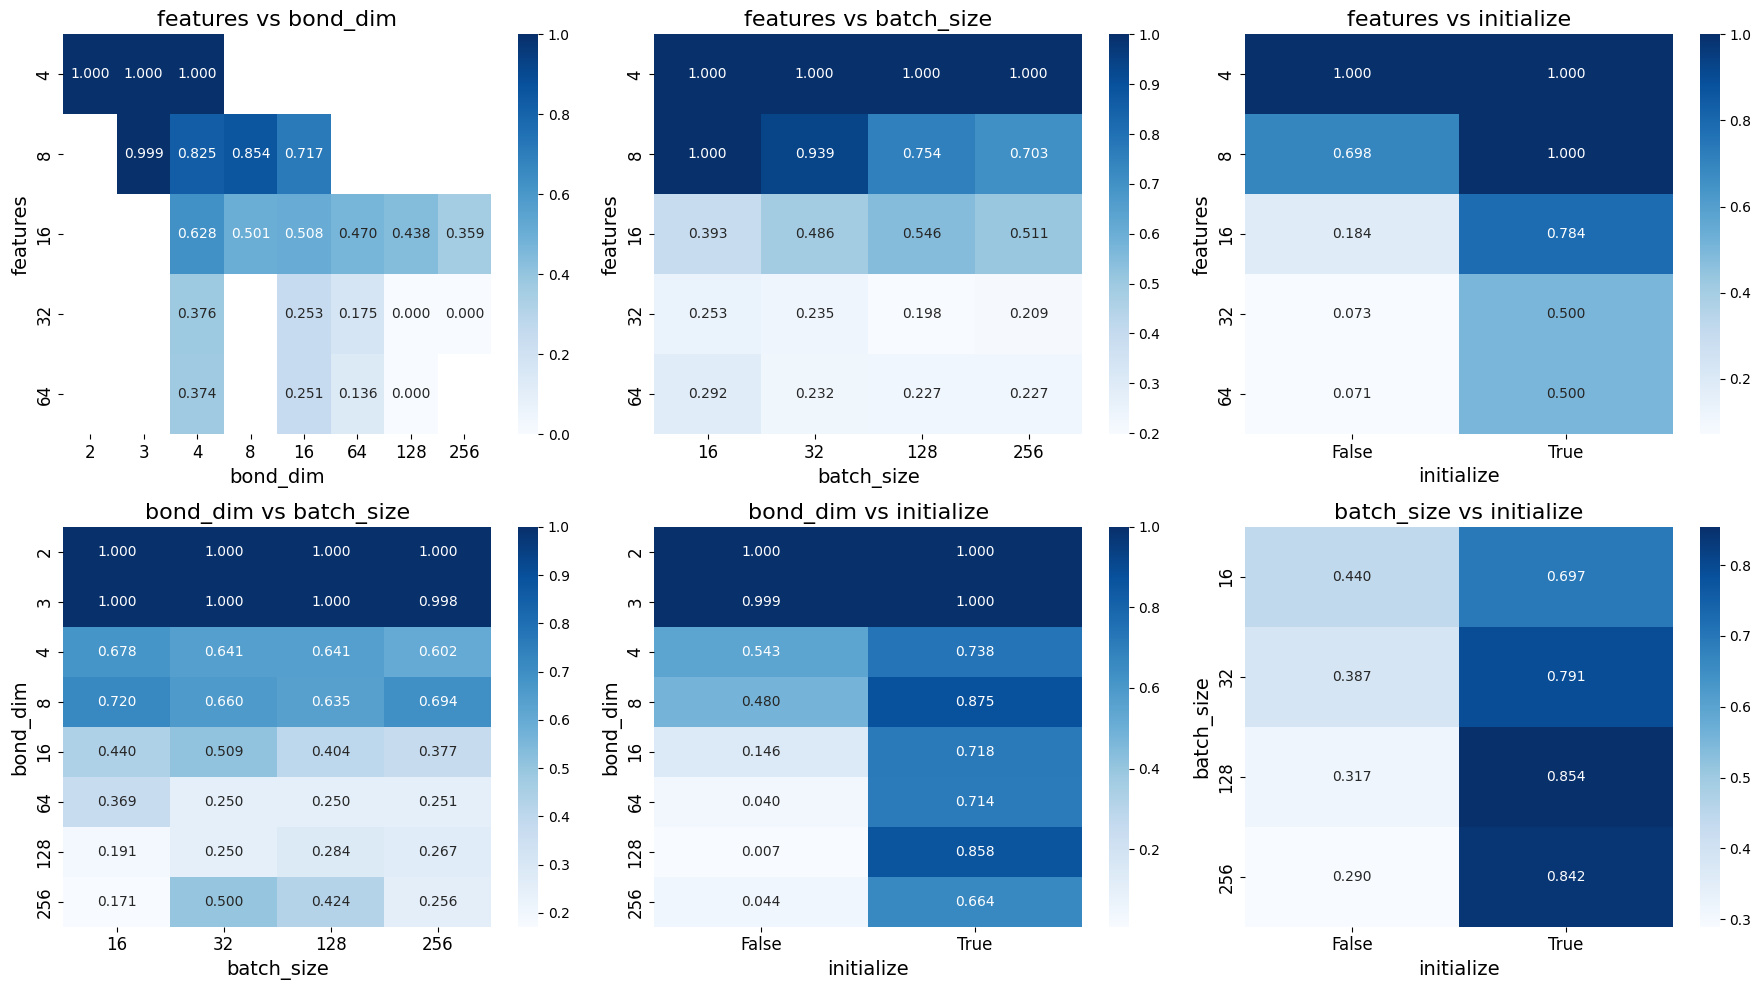

In [24]:
# plot heatmaps

fig, ax = heat_pairplot(data_df, data_df.columns[:4], 'test_acc')
for a in ax:
    a.tick_params(labelsize=FONTSIZE-2)
    a.set_title(a.get_title(), fontsize=FONTSIZE+2)
    a.set_xlabel(a.get_xlabel(), fontsize=FONTSIZE)
    a.set_ylabel(a.get_ylabel(), fontsize=FONTSIZE)

fig.tight_layout()

fig.savefig('data/grid_search/heatmaps.png', dpi=600)

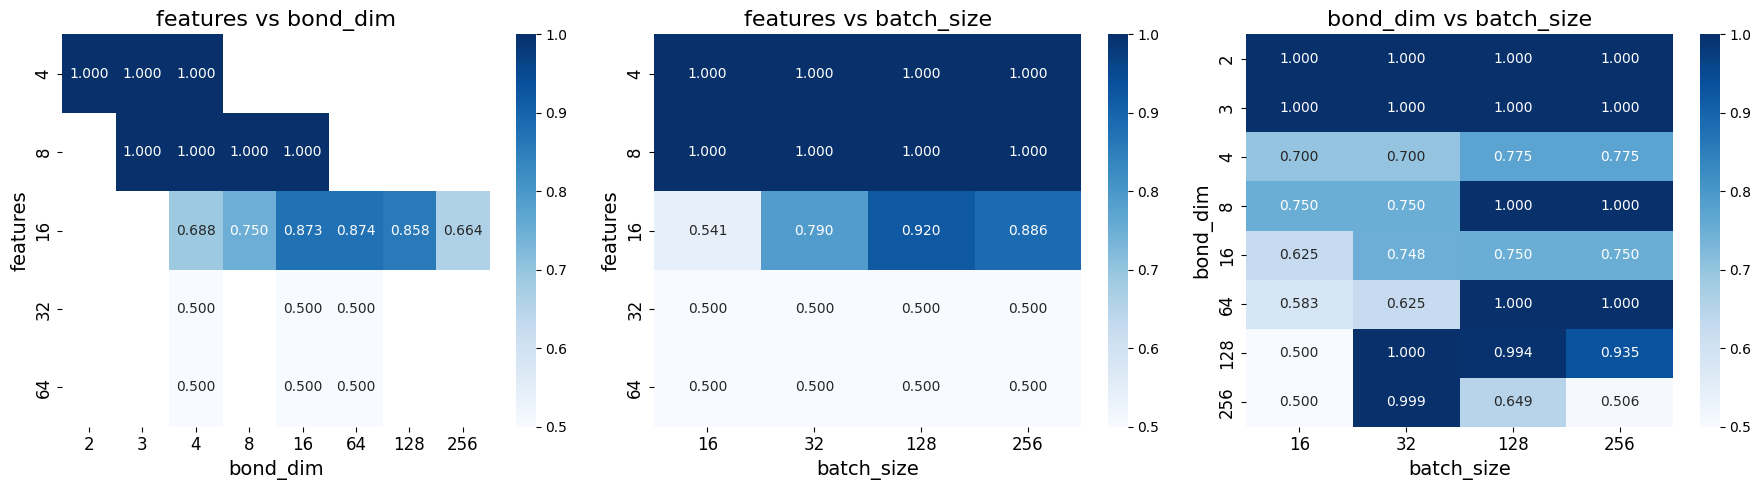

In [25]:

fig, ax = heat_pairplot(df_initTrue, df_initTrue.columns[:3], 'test_acc')
for a in ax:
    a.tick_params(labelsize=FONTSIZE-2)
    a.set_title(a.get_title(), fontsize=FONTSIZE+2)
    a.set_xlabel(a.get_xlabel(), fontsize=FONTSIZE)
    a.set_ylabel(a.get_ylabel(), fontsize=FONTSIZE)

fig.tight_layout()

fig.savefig('data/grid_search/heatmaps_initTrue.png', dpi=600)

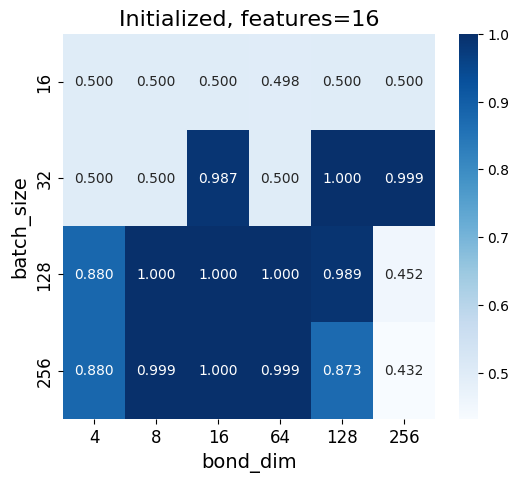

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

sns.heatmap(df_initTrue[(df_initTrue['features']==16) & (df_initTrue['dtype']=='torch.complex128')].pivot_table(index='batch_size', columns='bond_dim', values='test_acc', aggfunc='mean'), annot=True, fmt='.3f', cmap='Blues', ax=ax)
ax.set_title('Initialized, features=16', fontsize=FONTSIZE+2)
ax.set_xlabel('bond_dim', fontsize=FONTSIZE)
ax.set_ylabel('batch_size', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)

fig.savefig('data/grid_search/heatmap_initTrue_features16.png', dpi=600)

<Axes: xlabel='test_acc0', ylabel='Count'>

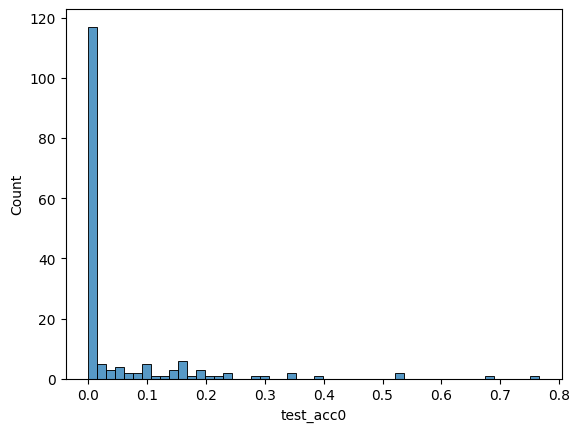

In [30]:
sns.histplot(df_initFalse['test_acc0'], bins=50)

## Dynamic range

In [3]:
root_dir = 'data/grid_search2/'
file_list = glob('model_*True_ttorch.float64*.pth', root_dir=root_dir)
print(len(file_list))

155


In [4]:
import re

feat_bd_tofile_dict = {}
for file in file_list:
    feat = int(re.findall(r'\d+', file.split('_')[1])[0])
    bd = int(re.findall(r'\d+', file.split('_')[2])[0])
    if feat not in feat_bd_tofile_dict:
        feat_bd_tofile_dict[feat] = {}
    feat_bd_tofile_dict[feat][bd] = [file] + feat_bd_tofile_dict[feat].get(bd, [])

In [5]:
features = list(feat_bd_tofile_dict.keys())
features.sort()
bds = []
for feat in features:
    bds += list(feat_bd_tofile_dict[feat].keys())
bds = np.unique(bds).tolist()

df = pd.DataFrame(index=pd.MultiIndex.from_product([features, bds], names=['feat', 'bd']), columns=['abs_min', 'abs_max', 'mean_min', 'mean_max', 'std_min', 'std_max', 'n'], dtype=float)

for feat in features:
    for bd in bds:
        if bd in feat_bd_tofile_dict[feat]:
            abs_tensors = np.stack([np.concatenate([np.abs(x.cpu().numpy().flatten()) for x in torch.load(root_dir + file).values()]) for file in feat_bd_tofile_dict[feat][bd]], axis=0)
            df.loc[feat, bd] = [np.min(abs_tensors), np.max(abs_tensors), np.mean(abs_tensors.min(-1)), np.mean(abs_tensors.max(-1)), 
                                np.std(abs_tensors.min(-1)), np.std(abs_tensors.max(-1)), abs_tensors.shape[0]]
        else:
            df.loc[feat, bd] = [None, None, None, None, None, None, 0]


In [6]:
df

abs_min   abs_max      mean_min  mean_max       std_min  \
feat bd                                                                   
4    2     3.987884e-35  1.275735  6.669258e-04  1.132071  1.357063e-03   
     3     4.638111e-16  1.273866  3.574235e-04  0.934746  7.479671e-04   
     4     3.652659e-31  1.271660  1.449368e-06  0.899319  4.312604e-06   
     8              NaN       NaN           NaN       NaN           NaN   
     16             NaN       NaN           NaN       NaN           NaN   
     64             NaN       NaN           NaN       NaN           NaN   
     128            NaN       NaN           NaN       NaN           NaN   
     256            NaN       NaN           NaN       NaN           NaN   
8    2              NaN       NaN           NaN       NaN           NaN   
     3     6.038781e-68  1.034742  8.304597e-06  0.956083  2.407715e-05   
     4    5.873681e-124  1.225649  7.325890e-20  0.934680  1.939860e-19   
     8    2.015862e-127  1.028487  1.939673e-26  0.917497  5.268297e-26   
     16   6.569301e-142  1.224678  8.286863e-18  0.928142  1.837444e-17   
     64             NaN       NaN           NaN       NaN           NaN   
     128            NaN       NaN           NaN       NaN           NaN   
     256            NaN       NaN           NaN       NaN           NaN   
16   2              NaN       NaN           NaN       NaN           NaN   
     3              NaN       NaN           NaN       NaN           NaN   
     4     4.704543e-36  0.650322  4.656139e-05  0.587422  7.501533e-05   
     8    3.956471e-138  1.043296  8.392619e-29  0.775228  2.517631e-28   
     16   5.171909e-134  1.065653  6.828883e-06  0.622468  1.287357e-05   
     64   1.778541e-144  1.090207  4.972729e-07  0.667055  6.959423e-07   
     128  2.329645e-176  2.805981  3.589992e-07  1.249534  1.004856e-06   
     256  1.222949e-141  5.478232  8.763151e-08  1.388667  1.957903e-07   
32   2              NaN       NaN           NaN       NaN           NaN   
     3              NaN       NaN           NaN       NaN           NaN   
     4     2.640966e-62  0.569242  9.062335e-06  0.502338  8.910478e-06   
     8              NaN       NaN           NaN       NaN           NaN   
     16    8.929658e-12  0.378196  6.462892e-07  0.329598  8.208659e-07   
     64    1.226993e-13  0.282358  9.539147e-09  0.242659  1.378586e-08   
     128            NaN       NaN           NaN       NaN           NaN   
     256            NaN       NaN           NaN       NaN           NaN   

           std_max     n  
feat bd                   
4    2    0.150636  10.0  
     3    0.230197  10.0  
     4    0.261367  10.0  
     8         NaN   0.0  
     16        NaN   0.0  
     64        NaN   0.0  
     128       NaN   0.0  
     256       NaN   0.0  
8    2         NaN   0.0  
     3    0.077914  10.0  
     4    0.141272  10.0  
     8    0.110754  10.0  
     16   0.189726  10.0  
     64        NaN   0.0  
     128       NaN   0.0  
     256       NaN   0.0  
16   2         NaN   0.0  
     3         NaN   0.0  
     4    0.039952  10.0  
     8    0.212776  10.0  
     16   0.351578  10.0  
     64   0.419146  10.0  
     128  0.744551  10.0  
     256  1.502309  10.0  
32   2         NaN   0.0  
     3         NaN   0.0  
     4    0.039141  10.0  
     8         NaN   0.0  
     16   0.059179  10.0  
     64   0.027530   5.0  
     128       NaN   0.0  
     256       NaN   0.0

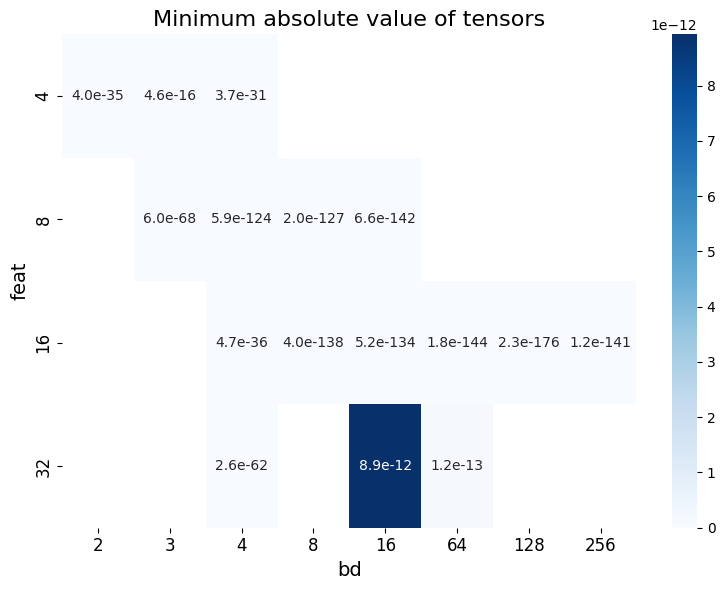

In [9]:
fig, ax = heat_pairplot(df, ['feat', 'bd'], 'abs_min', fmt='2.1e')
ax[0].set_title('Minimum absolute value of tensors', fontsize=FONTSIZE+2)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=FONTSIZE)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=FONTSIZE)
ax[0].tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()
fig.savefig(root_dir + 'heatmap_abs_min.png', dpi=600)

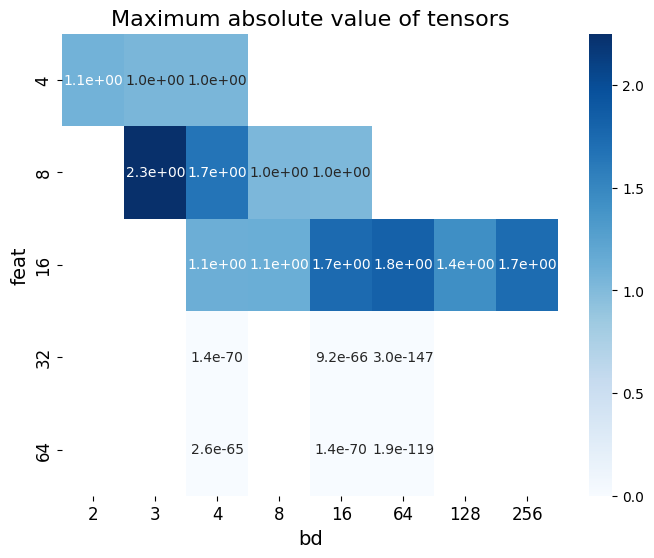

In [58]:
fog, ax = heat_pairplot(df, ['feat', 'bd'], 'abs_max', fmt='2.1e')
ax[0].set_title('Maximum absolute value of tensors', fontsize=FONTSIZE+2)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=FONTSIZE)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=FONTSIZE)
ax[0].tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()
fig.savefig('data/grid_search/heatmap_abs_max.png', dpi=600)

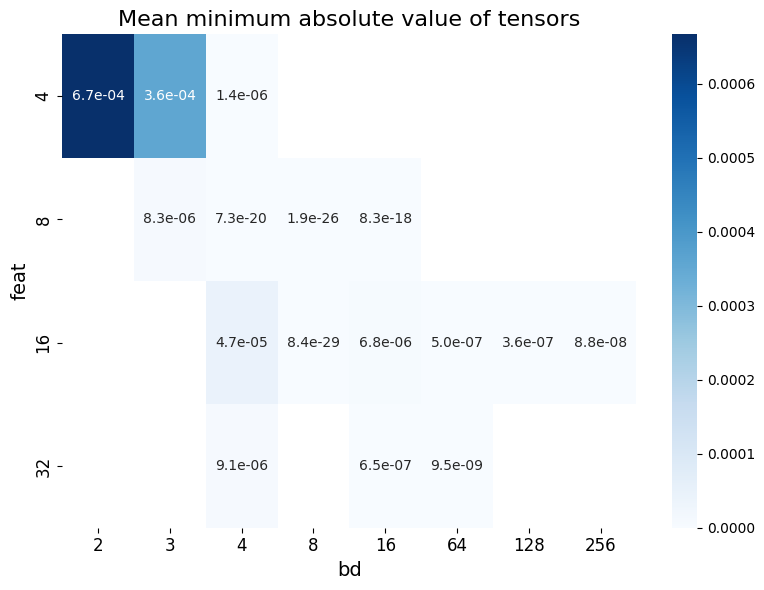

In [10]:
fig, ax = heat_pairplot(df, ['feat', 'bd'], 'mean_min', fmt='2.1e')
ax[0].set_title('Mean minimum absolute value of tensors', fontsize=FONTSIZE+2)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=FONTSIZE)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=FONTSIZE)
ax[0].tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()
fig.savefig('data/grid_search/heatmap_mean_min.png', dpi=600)

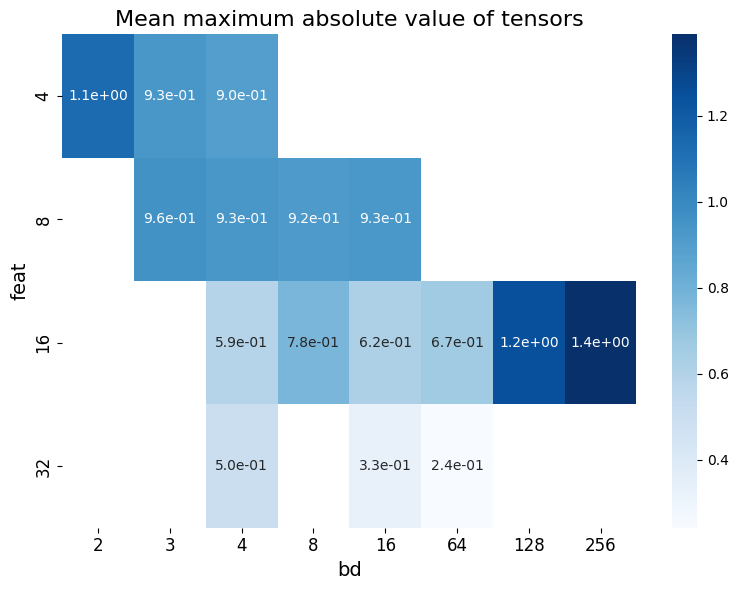

In [11]:
fig, ax = heat_pairplot(df, ['feat', 'bd'], 'mean_max', fmt='2.1e')
ax[0].set_title('Mean maximum absolute value of tensors', fontsize=FONTSIZE+2)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=FONTSIZE)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=FONTSIZE)
ax[0].tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()
fig.savefig(root_dir + 'heatmap_mean_max.png', dpi=600)

# Fixed precision analysis

In [40]:
datadir = 'data/grid_search_fp2_striped/'
DATASET = datadir.split('_')[-1][:-1]
df = pd.read_csv(datadir + 'grid_search.csv', index_col=0)
df = df.fillna(0)
df

,bond_dim,quantize,wl,il,sample,loss,train_acc,test_acc,train_acc0,test_acc0,auc,time
0,3,True,4.0,1.0,0,0.269572,0.5000,0.500,0.5000,0.500,0.500000,113.683911
1,3,True,4.0,1.0,1,0.268530,0.5000,0.500,0.5000,0.500,0.501000,121.450653
2,3,True,4.0,1.0,2,0.268983,0.5000,0.500,0.5000,0.500,0.500000,126.721748
3,3,True,4.0,1.0,3,0.269309,0.5000,0.500,0.5000,0.500,0.500000,115.664275
4,3,True,4.0,1.0,4,0.268782,0.5000,0.500,0.5000,0.500,0.500000,124.414449
...,...,...,...,...,...,...,...,...,...,...,...,...
455,8,False,0.0,0.0,5,0.126366,0.7504,0.762,0.6379,0.654,0.541620,95.807179
456,8,False,0.0,0.0,6,0.126684,0.7504,0.762,0.5296,0.539,0.549888,94.808261
457,8,False,0.0,0.0,7,0.124958,0.7504,0.762,0.6248,0.641,0.539852,95.749394
458,8,False,0.0,0.0,8,0.125656,0.7504,0.762,0.6272,0.620,0.540408,95.563395


In [44]:
df[(df['bond_dim'] == 3) & (df['wl'] == 6) & (df['il']==2)]

,bond_dim,quantize,wl,il,sample,loss,train_acc,test_acc,train_acc0,test_acc0,auc,time
30,3,True,6.0,2.0,0,0.183175,0.7470,0.759,0.5,0.5,0.851950,113.987875
31,3,True,6.0,2.0,1,0.290262,0.5000,0.500,0.5,0.5,0.575000,114.858561
32,3,True,6.0,2.0,2,0.287622,0.5000,0.500,0.5,0.5,0.501000,115.886746
33,3,True,6.0,2.0,3,0.087579,0.9620,0.971,0.5,0.5,1.000000,115.965289
34,3,True,6.0,2.0,4,0.291648,0.5000,0.500,0.5,0.5,0.715086,113.624819
35,3,True,6.0,2.0,5,0.193159,0.7264,0.710,0.5,0.5,0.913428,114.548253
36,3,True,6.0,2.0,6,0.288220,0.5000,0.500,0.5,0.5,0.500000,113.689080
37,3,True,6.0,2.0,7,0.181672,0.7416,0.730,0.5,0.5,0.842044,114.423726
38,3,True,6.0,2.0,8,0.289685,0.5000,0.500,0.5,0.5,0.519000,114.237820
39,3,True,6.0,2.0,9,0.289419,0.5000,0.500,0.5,0.5,0.523000,115.315118


In [3]:
#df = df[df['batch_size'] == 32]

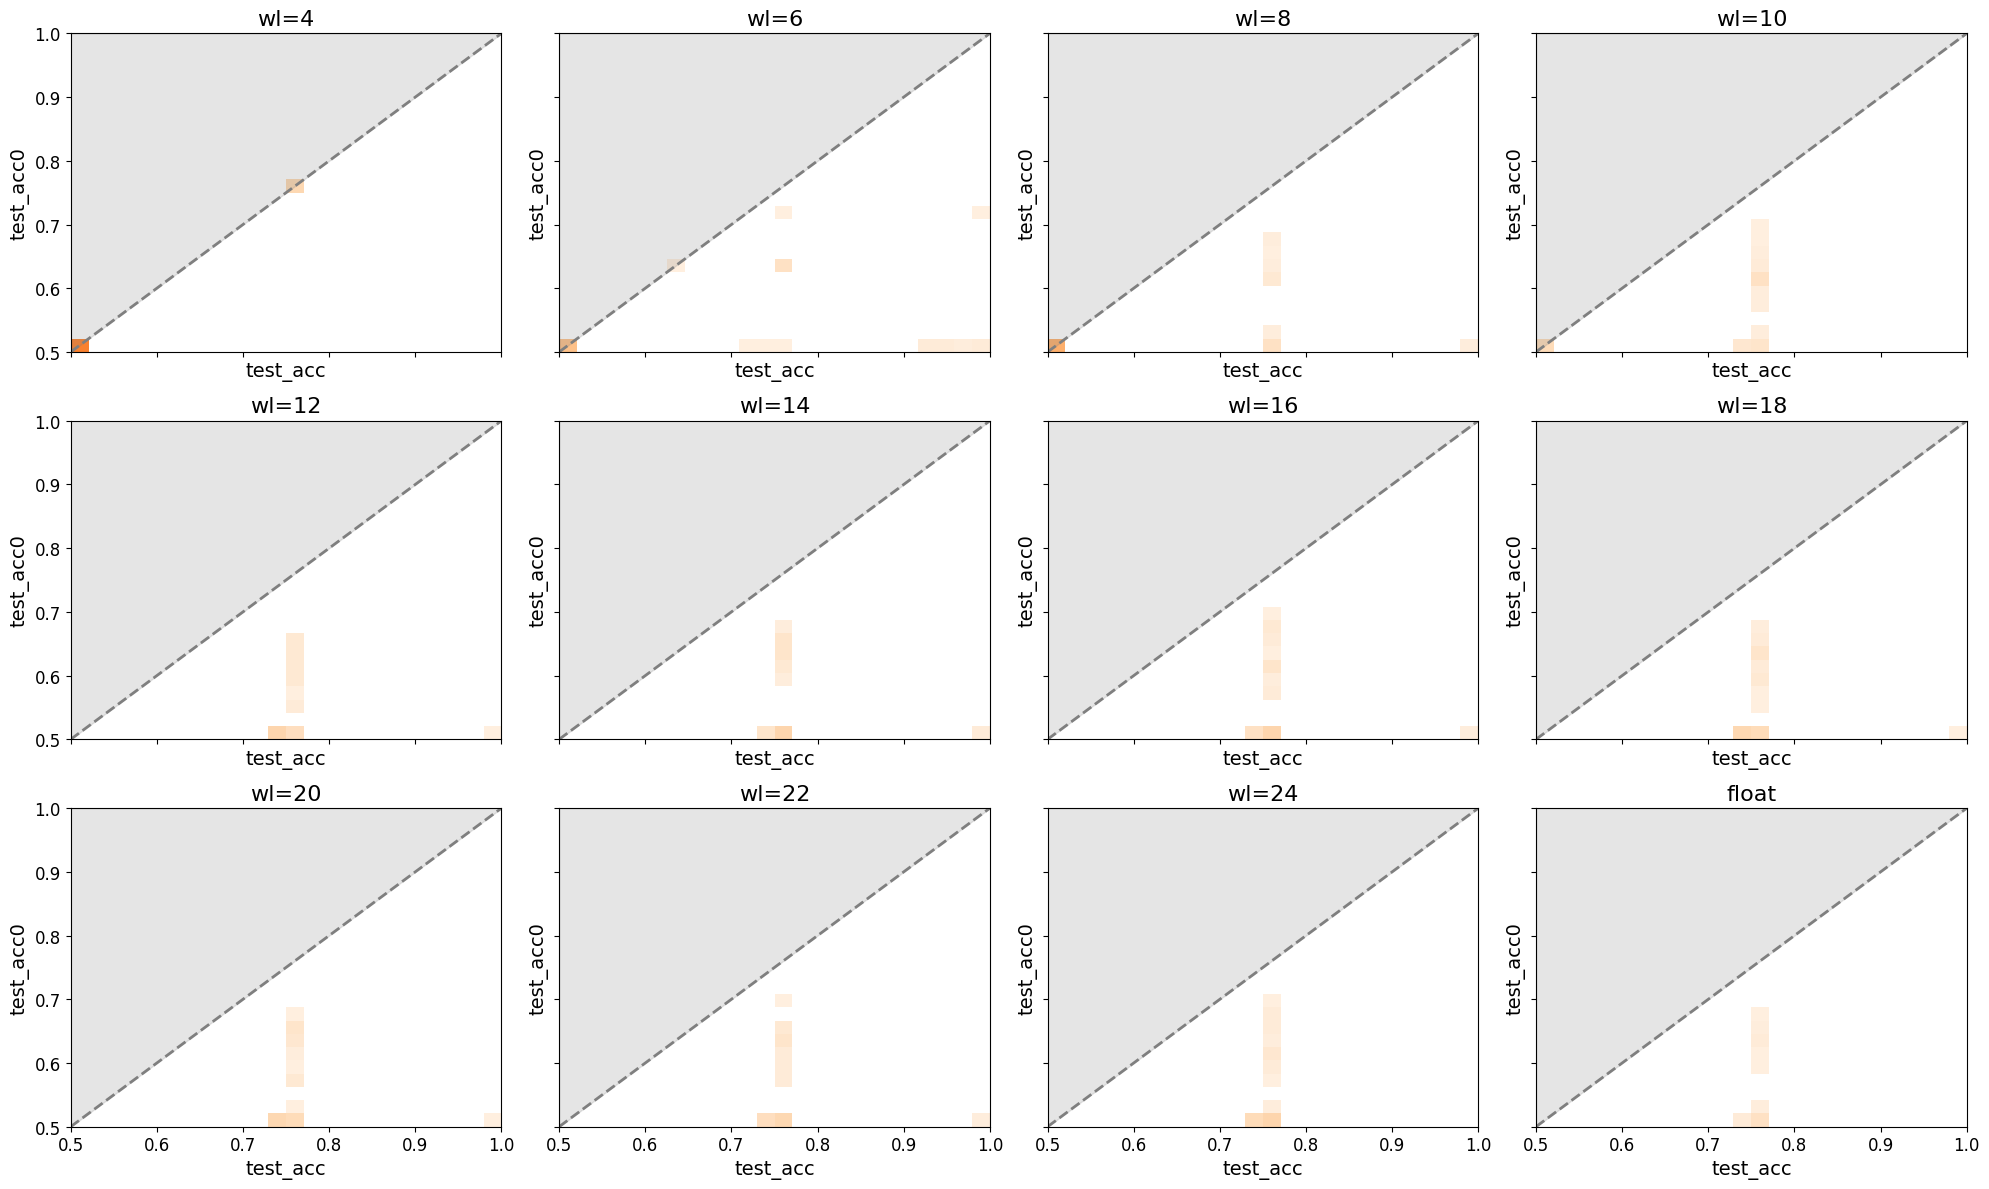

In [41]:
fig, axs = plt.subplots(3, 4, figsize=(20, 12), sharex=True, sharey=True)
axs = axs.flatten()
edges = np.linspace(0.5, 1.0, 25)

for i, wl in enumerate(df['wl'].unique()):
    axs[i].hist2d(df[df['wl'] == wl]['test_acc'], df[df['wl'] == wl]['test_acc0'], cmap='Oranges', bins=edges, cmin=0.1, vmin=-2, vmax=len(df)//8)
    axs[i].plot([0.5, 1.0], [0.5, 1.0], color='tab:grey', linestyle='--', lw=2)
    axs[i].fill_between([0.5, 1.0], [0.5, 1.0], 1, color='tab:grey', alpha=0.2)
    axs[i].set_title(f'wl={int(wl)}' if wl > 0 else 'float', fontsize=FONTSIZE+2)
    axs[i].set_xlabel('test_acc', fontsize=FONTSIZE)
    axs[i].set_ylabel('test_acc0', fontsize=FONTSIZE)
    axs[i].tick_params(labelsize=FONTSIZE-2)


fig.tight_layout()
fig.savefig(datadir + DATASET + '_heatmaps.png', dpi=600)

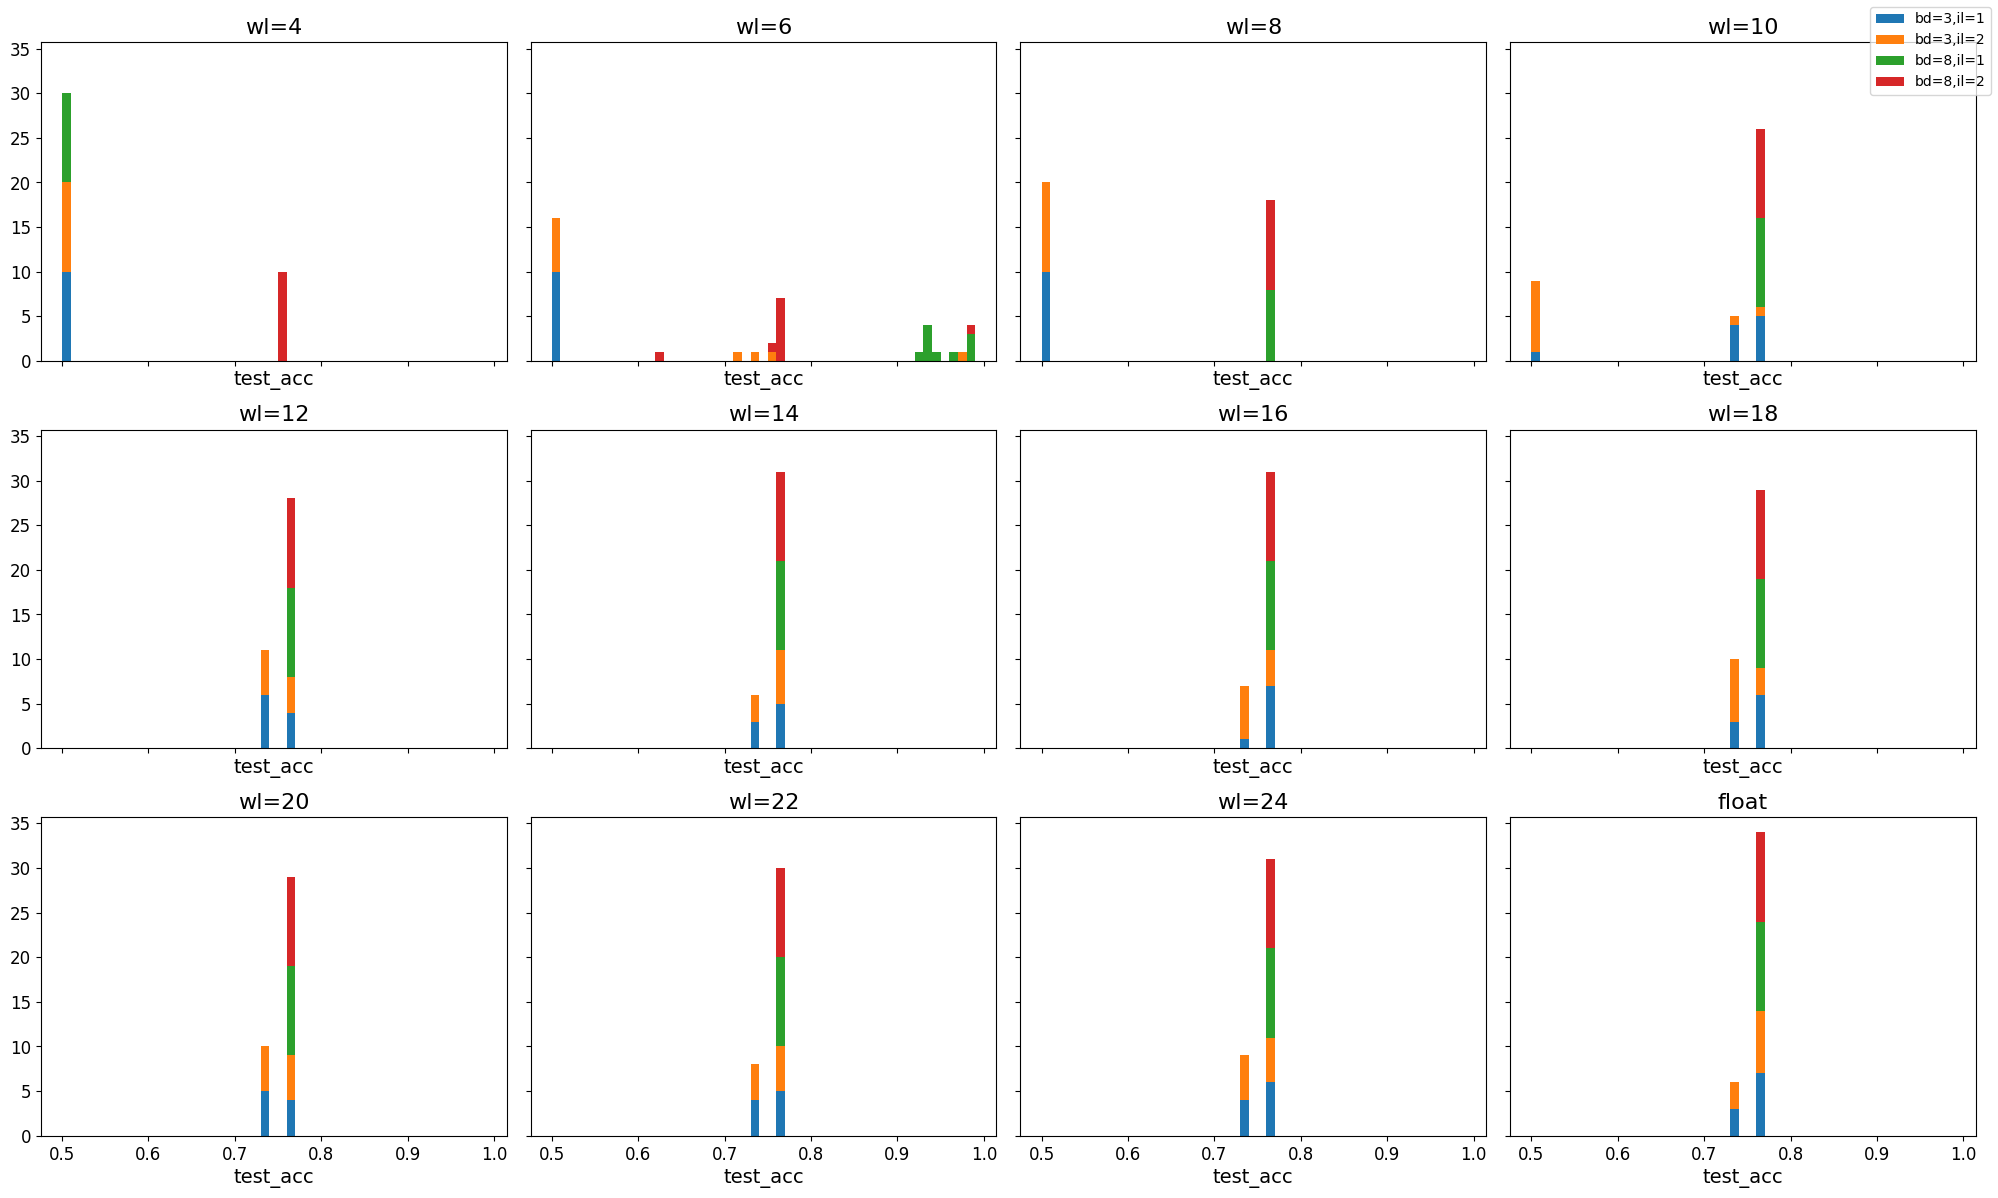

In [42]:
fig, axs = plt.subplots(3, 4, figsize=(20, 12), sharex=True, sharey=True)
axs = axs.flatten()
bins = np.linspace(0.5, 0.99, 50)

df_bd3 = df[df['bond_dim'] == 3]
df_bd8 = df[df['bond_dim'] == 8]

for i, wl in enumerate(df['wl'].unique()):
    axs[i].hist([df_bd3[(df_bd3['wl'] == wl) & ((df_bd3['il'] == 1) | (df_bd3['il'] == 0))]['test_acc'], 
                 df_bd3[(df_bd3['wl'] == wl) & ((df_bd3['il'] == 2) | (df_bd3['il'] == 0))]['test_acc'], 
                 df_bd8[(df_bd8['wl'] == wl) & ((df_bd8['il'] == 1) | (df_bd8['il'] == 0))]['test_acc'], 
                 df_bd8[(df_bd8['wl'] == wl) & ((df_bd8['il'] == 2) | (df_bd8['il'] == 0))]['test_acc']], 
                 bins=bins, label=[f'bd={bd},il={il}' for bd in [3, 8] for il in [1, 2]], stacked=True)
    axs[i].set_title(f'wl={int(wl)}' if wl > 0 else 'float', fontsize=FONTSIZE+2)
    axs[i].set_xlabel('test_acc', fontsize=FONTSIZE)
    axs[i].tick_params(labelsize=FONTSIZE-2)


fig.legend([f'bd={bd},il={il}' for bd in [3, 8] for il in [1, 2]])
fig.tight_layout()
fig.savefig(datadir + DATASET + '_hists.png', dpi=600)

In [95]:
df[df['test_acc'] > 0.9]

,bond_dim,quantize,wl,il,sample,loss,train_acc,test_acc,train_acc0,test_acc0,auc,time
33,3,True,6.0,2.0,3,0.087579,0.9620,0.971,0.5000,0.500,1.000000,115.965289
99,3,True,12.0,2.0,9,0.009987,0.9988,0.996,0.5000,0.500,1.000000,114.005605
102,3,True,14.0,1.0,2,0.007066,0.9997,1.000,0.5000,0.500,1.000000,114.812027
104,3,True,14.0,1.0,4,0.007150,1.0000,1.000,0.5000,0.500,1.000000,113.726069
119,3,True,14.0,2.0,9,0.010028,0.9983,0.999,0.5000,0.500,1.000000,113.850784
121,3,True,16.0,1.0,1,0.007043,1.0000,1.000,0.5000,0.500,1.000000,115.447551
123,3,True,16.0,1.0,3,0.007121,0.9996,1.000,0.5000,0.500,1.000000,117.664264
143,3,True,18.0,1.0,3,0.007117,0.9999,1.000,0.5000,0.500,1.000000,114.233593
164,3,True,20.0,1.0,4,0.007050,1.0000,1.000,0.5000,0.500,1.000000,114.655680
188,3,True,22.0,1.0,8,0.007048,1.0000,1.000,0.5000,0.500,1.000000,113.261538


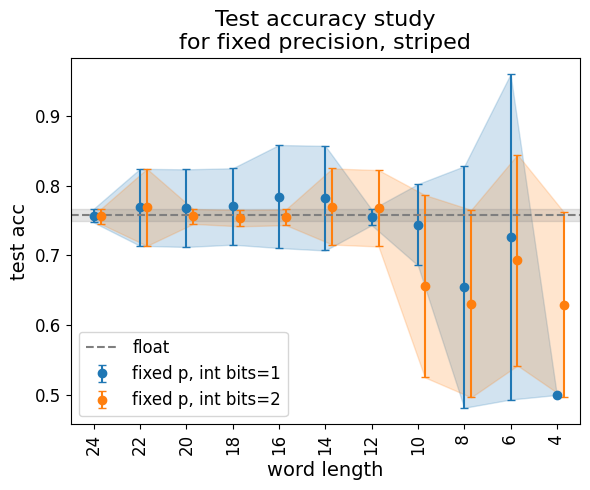

In [43]:
m_acc_f, std_acc_f = df[df['quantize'] == False]['test_acc'].mean(), df[df['quantize'] == False]['test_acc'].std()

wls = np.sort(df['wl'].unique())[::-1][:-1] # remove 0 i.e. float
ils = np.sort(df['il'].unique())[1:]        # remove 0 i.e. float

m_acc_q, std_acc_q = zip(*[(df[(df['wl'] == wl) & (df['il'] == il)]['test_acc'].mean(), 
                            df[(df['wl'] == wl) & (df['il'] == il)]['test_acc'].std()) 
                           for wl in wls for il in ils])
m_acc_q, std_acc_q = np.array(m_acc_q), np.array(std_acc_q)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

trans = matplotlib.transforms.offset_copy(ax.transData, fig=fig, x=5, y=0, units='points')
ax.errorbar(range(len(wls)), m_acc_q[::2], yerr=std_acc_q[::2], fmt='o', capthick=1, capsize=3, label='fixed p, int bits=1')
ax.errorbar(range(len(wls)), m_acc_q[1::2], yerr=std_acc_q[1::2], fmt='o', capthick=1, capsize=3, label='fixed p, int bits=2', transform=trans)
ax.fill_between(range(len(wls)), m_acc_q[::2]-std_acc_q[::2], m_acc_q[::2]+std_acc_q[::2], color='tab:blue', alpha=0.2)
ax.fill_between(range(len(wls)), m_acc_q[1::2]-std_acc_q[1::2], m_acc_q[1::2]+std_acc_q[1::2], color='tab:orange', alpha=0.2, transform=trans)
ax.axhline(m_acc_f, color='tab:grey', linestyle='--', label='float')
ax.axhspan(m_acc_f-std_acc_f, m_acc_f+std_acc_f, color='tab:grey', alpha=0.2)
ax.set_xticks(range(len(wls)))
ax.set_xticklabels([f'{wl:2.0f}' for wl in wls], rotation=90, fontsize=FONTSIZE-2)
ax.set_title(f'Test accuracy study\nfor fixed precision, {DATASET}', fontsize=FONTSIZE+2)
ax.set_xlabel('word length', fontsize=FONTSIZE)
ax.set_ylabel('test acc', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)
ax.legend(fontsize=FONTSIZE-2, loc='lower left')
fig.tight_layout()
fig.savefig(datadir + DATASET + '_acc_study.png', dpi=600)

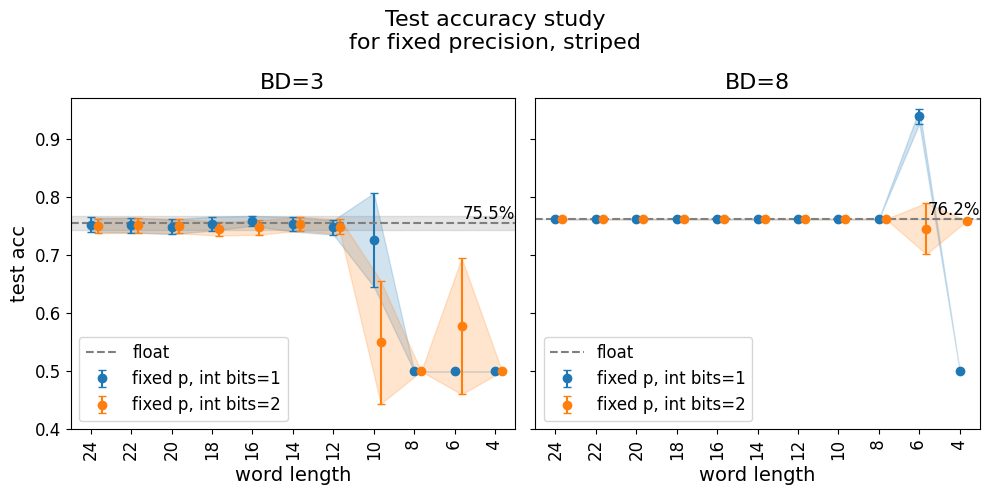

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
wls = np.sort(df['wl'].unique())[::-1][:-1] # remove 0 i.e. float
ils = np.sort(df['il'].unique())[1:]        # remove 0 i.e. float

ns=[]
cut = .971

for bd, ax in zip([3, 8], axs):
    df_bd = df[(df['bond_dim'] == bd) & (df['test_acc'] < cut)]

    m_acc_f, std_acc_f = df_bd[df_bd['quantize'] == False]['test_acc'].mean(), df_bd[df_bd['quantize'] == False]['test_acc'].std()

    m_acc_q, std_acc_q, n = zip(*[(df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il)]['test_acc'].mean(), 
                                df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il)]['test_acc'].std(),
                                df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il)]['test_acc'].count())
                            for wl in wls for il in ils])
    ns.append(n)
    m_acc_q, std_acc_q = np.array(m_acc_q), np.array(std_acc_q)

    

    trans = matplotlib.transforms.offset_copy(ax.transData, fig=fig, x=5, y=0, units='points')
    ax.errorbar(range(len(wls)), m_acc_q[::2], yerr=std_acc_q[::2], fmt='o', capthick=1, capsize=3, label='fixed p, int bits=1')
    ax.errorbar(range(len(wls)), m_acc_q[1::2], yerr=std_acc_q[1::2], fmt='o', capthick=1, capsize=3, label='fixed p, int bits=2', transform=trans)
    ax.fill_between(range(len(wls)), m_acc_q[::2]-std_acc_q[::2], m_acc_q[::2]+std_acc_q[::2], color='tab:blue', alpha=0.2)
    ax.fill_between(range(len(wls)), m_acc_q[1::2]-std_acc_q[1::2], m_acc_q[1::2]+std_acc_q[1::2], color='tab:orange', alpha=0.2, transform=trans)
    ax.axhline(m_acc_f, color='tab:grey', linestyle='--', label='float')
    ax.axhspan(m_acc_f-std_acc_f, m_acc_f+std_acc_f, color='tab:grey', alpha=0.2)
    ax.set_xticks(range(len(wls)))
    ax.set_xticklabels([f'{wl:2.0f}' for wl in wls], rotation=90, fontsize=FONTSIZE-2)
    ax.set_title(f'BD={bd}', fontsize=FONTSIZE+2)
    ax.set_xlabel('word length', fontsize=FONTSIZE)
    ax.set_ylim(0.4, cut)
    ax.set_xlim(-0.5, len(wls)-0.5)
    ax.text(1., (m_acc_f-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]), f'{m_acc_f:2.1%}', transform=ax.transAxes, fontsize=FONTSIZE-2, ha='right', va='bottom')
    ax.tick_params(labelsize=FONTSIZE-2)
    ax.legend(fontsize=FONTSIZE-2, loc='lower left')

axs[0].set_ylabel('test acc', fontsize=FONTSIZE)

fig.suptitle(f'Test accuracy study\nfor fixed precision, {DATASET}', fontsize=FONTSIZE+2)
fig.tight_layout()
fig.savefig(datadir + DATASET + f'_acc_study_bd_cut{cut}.png', dpi=600)

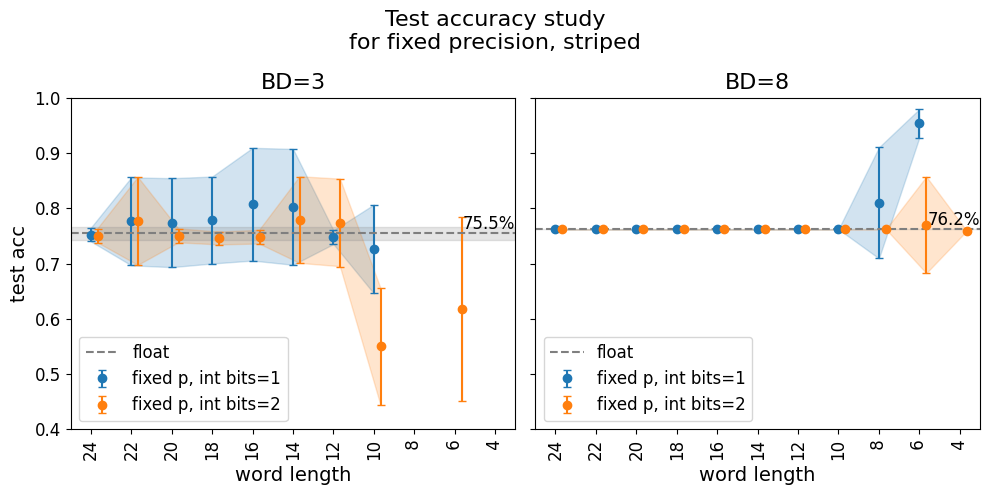

In [49]:
# cut based on std

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
wls = np.sort(df['wl'].unique())[::-1][:-1] # remove 0 i.e. float
ils = np.sort(df['il'].unique())[1:]        # remove 0 i.e. float

ns=[]
n_std = 4

for bd, ax in zip([3, 8], axs):
    df_bd = df[df['bond_dim'] == bd]

    m_acc_f, std_acc_f = df_bd[df_bd['quantize'] == False]['test_acc'].mean(), df_bd[df_bd['quantize'] == False]['test_acc'].std()

    mode_acc_q, std0_acc_q, n = zip(*[(df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il)]['test_acc'].mode(), 
                                   df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il)]['test_acc'].std(),
                                   df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il)]['test_acc'].count())
                                  for wl in wls for il in ils])
    m_acc_q, std_acc_q, n = zip(*[(df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il) & ((df_bd['test_acc'] - mode_acc_q[i*len(ils)+j].iloc[-1]).abs() < n_std*std0_acc_q[i*len(ils)+j])]['test_acc'].mean(), 
                                   df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il) & ((df_bd['test_acc'] - mode_acc_q[i*len(ils)+j].iloc[-1]).abs() < n_std*std0_acc_q[i*len(ils)+j])]['test_acc'].std(),
                                   df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il) & ((df_bd['test_acc'] - mode_acc_q[i*len(ils)+j].iloc[-1]).abs() < n_std*std0_acc_q[i*len(ils)+j])]['test_acc'].count())
                                  for i, wl in enumerate(wls) for j, il in enumerate(ils)])
    ns.append(n)
    m_acc_q, std_acc_q = np.array(m_acc_q), np.array(std_acc_q)

    

    trans = matplotlib.transforms.offset_copy(ax.transData, fig=fig, x=5, y=0, units='points')
    ax.errorbar(range(len(wls)), m_acc_q[::2], yerr=std_acc_q[::2], fmt='o', capthick=1, capsize=3, label='fixed p, int bits=1')
    ax.errorbar(range(len(wls)), m_acc_q[1::2], yerr=std_acc_q[1::2], fmt='o', capthick=1, capsize=3, label='fixed p, int bits=2', transform=trans)
    ax.fill_between(range(len(wls)), m_acc_q[::2]-std_acc_q[::2], m_acc_q[::2]+std_acc_q[::2], color='tab:blue', alpha=0.2)
    ax.fill_between(range(len(wls)), m_acc_q[1::2]-std_acc_q[1::2], m_acc_q[1::2]+std_acc_q[1::2], color='tab:orange', alpha=0.2, transform=trans)
    ax.axhline(m_acc_f, color='tab:grey', linestyle='--', label='float')
    ax.axhspan(m_acc_f-std_acc_f, m_acc_f+std_acc_f, color='tab:grey', alpha=0.2)
    ax.set_xticks(range(len(wls)))
    ax.set_xticklabels([f'{wl:2.0f}' for wl in wls], rotation=90, fontsize=FONTSIZE-2)
    ax.set_title(f'BD={bd}', fontsize=FONTSIZE+2)
    ax.set_xlabel('word length', fontsize=FONTSIZE)
    
    ax.tick_params(labelsize=FONTSIZE-2)
    ax.set_ylim(0.4, 1.)
    ax.set_xlim(-0.5, len(wls)-0.5)
    ax.text(1., (m_acc_f-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]), f'{m_acc_f:2.1%}', transform=ax.transAxes, fontsize=FONTSIZE-2, ha='right', va='bottom')
    
    ax.legend(fontsize=FONTSIZE-2, loc='lower left')

axs[0].set_ylabel('test acc', fontsize=FONTSIZE)
fig.suptitle(f'Test accuracy study\nfor fixed precision, {DATASET}', fontsize=FONTSIZE+2)
fig.tight_layout()
fig.savefig(datadir + DATASET + f'_acc_study_bd_stdcut{n_std}.png', dpi=600)

In [93]:
std0_acc_q

(1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 0.10034961108267658,
 1.1702778228589004e-16,
 0.025734542285936735,
 0.08720786152125914,
 0.0,
 1.1702778228589004e-16)

In [79]:
(df_bd['test_acc'] - mode_acc_q[0].item()).abs()

230    0.262
231    0.262
232    0.262
233    0.262
234    0.262
       ...  
455    0.000
456    0.000
457    0.000
458    0.000
459    0.000
Name: test_acc, Length: 230, dtype: float64

# Permutations

In [2]:
df = pd.read_csv('data/grid_search_perm/grid_search.csv', index_col=0)
df

,permutation,sample,loss,train_acc,test_acc,train_acc0,test_acc0,auc,time
0,"[6, 1, 3, 0, 7, 2, 4, 5]",0,0.117660,0.6105,0.580,0.5401,0.539,0.656713,76.032220
1,"[6, 1, 3, 0, 7, 2, 4, 5]",1,0.117344,0.6221,0.560,0.5181,0.553,0.656741,75.699637
2,"[6, 1, 3, 0, 7, 2, 4, 5]",2,0.117203,0.6293,0.538,0.5206,0.539,0.655649,79.365778
3,"[6, 1, 3, 0, 7, 2, 4, 5]",3,0.117260,0.6228,0.560,0.5370,0.547,0.656721,80.548868
4,"[6, 1, 3, 0, 7, 2, 4, 5]",4,0.117518,0.6267,0.554,0.5456,0.544,0.657261,80.555181
...,...,...,...,...,...,...,...,...,...
95,"[1, 4, 2, 5, 0, 3, 6, 7]",0,0.117851,0.6321,0.511,0.5492,0.532,0.649363,82.505884
96,"[1, 4, 2, 5, 0, 3, 6, 7]",1,0.118227,0.6280,0.535,0.5543,0.553,0.649583,80.674456
97,"[1, 4, 2, 5, 0, 3, 6, 7]",2,0.117937,0.6297,0.509,0.5377,0.558,0.649395,81.640622
98,"[1, 4, 2, 5, 0, 3, 6, 7]",3,0.117662,0.6307,0.511,0.5444,0.529,0.649935,81.636140


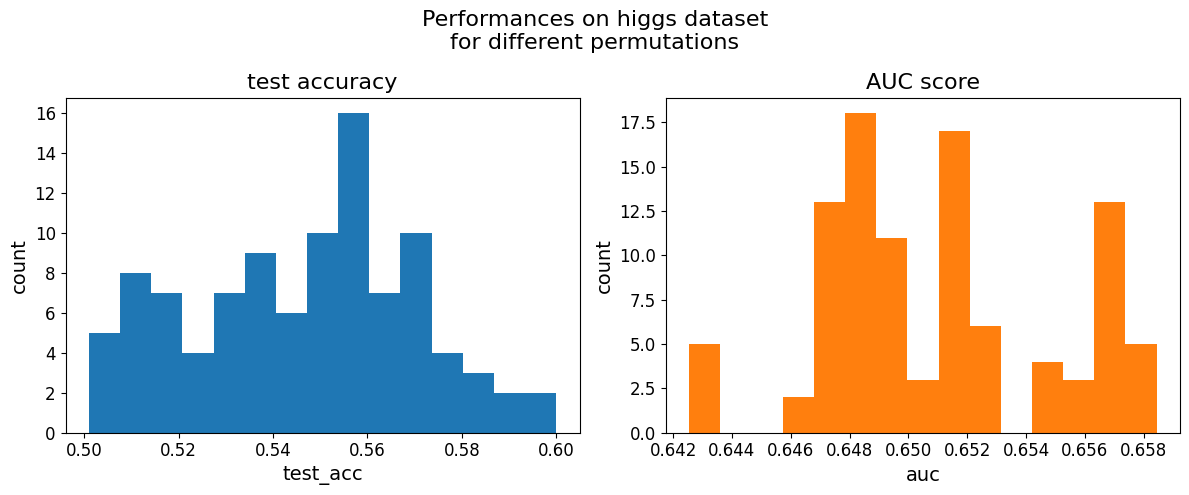

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

bins = 15

axs[0].hist(df['test_acc'], bins=bins, color='tab:blue')
axs[0].set_title('test accuracy', fontsize=FONTSIZE+2)
axs[0].set_xlabel('test_acc', fontsize=FONTSIZE)
axs[0].set_ylabel('count', fontsize=FONTSIZE)
axs[0].tick_params(labelsize=FONTSIZE-2)

axs[1].hist(df['auc'], bins=bins, color='tab:orange')
axs[1].set_title('AUC score', fontsize=FONTSIZE+2)
axs[1].set_xlabel('auc', fontsize=FONTSIZE)
axs[1].set_ylabel('count', fontsize=FONTSIZE)
axs[1].tick_params(labelsize=FONTSIZE-2)


fig.suptitle('Performances on higgs dataset\nfor different permutations', fontsize=FONTSIZE+2)
fig.tight_layout()
fig.savefig('data/grid_search_perm/higgs_perf.png', dpi=600)